# Mango Leaf Disease Classification with Convolutional Neural Networks (CNN)

# 1. Business Understanding

The goal of this project is to develop a deep learning model that can classify mango leaf images into four categories:  
- Healthy mango leaves.  
- Mango leaves affected by anthracnose.  
- Mango leaves affected by bacterial canker.  
- Mango leaves affected by powdery mildew.  

This model can assist farmers in early disease detection, helping to minimize crop losses.

# 2. Data Understanding

The dataset used in this project was downloaded from the Kaggle website at the following link:

https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset/data

### 2.1 Import Library

In [ ]:
# Install the splitfolders library
!pip install split-folders

# Import required libraries
import os
import shutil
import random
import zipfile
import requests
import splitfolders
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### 2.2 Download Dataset

In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/1M1Smhp3VwP9wJ8HQsNlyJyebSjJcR6cJ/view?usp=sharing'

Downloading...
From (original): https://drive.google.com/uc?id=1M1Smhp3VwP9wJ8HQsNlyJyebSjJcR6cJ
From (redirected): https://drive.google.com/uc?id=1M1Smhp3VwP9wJ8HQsNlyJyebSjJcR6cJ&confirm=t&uuid=c5d105ff-9701-43db-9676-418132349006
To: /content/MangoLeafsDisease.zip
100% 48.5M/48.5M [00:00<00:00, 103MB/s]


### 2.3 Extract Dataset

In [ ]:
# Open the ZIP file containing the dataset
zip_ref = zipfile.ZipFile('./MangoLeafsDisease.zip', 'r')

# Extract all files from the ZIP archive
zip_ref.extractall('./MangoLeafsDisease')

# Close the ZIP file
zip_ref.close()

### 2.4 Count the total number of images in the dataset

In [ ]:
# Define the dataset directory
dataset_dir = './MangoLeafsDisease/MangoLeafsDisease'

# Count the total number of images in the dataset
total_images = sum([len(files) for r, d, files in os.walk(dataset_dir)])
print(f"Total Images in Dataset: {total_images} Images")

Total Images in Dataset: 2000 Images


### 2.5 Display class labels in the dataset

In [ ]:
labels = [name for name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, name))]
print(labels)

['healthy', 'anthracnose', 'bacterial_canker', 'powdery_mildew']


### 2.6 Image properties

In [ ]:
from PIL import Image

# Load a random image from the dataset
label = random.choice(labels)
img_path = os.path.join(dataset_dir, label, random.choice(os.listdir(os.path.join(dataset_dir, label))))
img = Image.open(img_path)

# Get image properties
width, height = img.size
image_format = img.format

# Check color mode
mode = img.mode
if mode == 'RGB':
    color_type = 'RGB (Color)'
elif mode == 'L':
    color_type = 'Grayscale'
else:
    color_type = mode

# Print image details
print(f"Image size: {width} x {height} pixels")
print(f"Image format: {image_format}")
print(f"Color type: {color_type}")

Image size: 240 x 320 pixels
Image format: JPEG
Color type: RGB (Color)


### 2.7 Display one sample image from each class

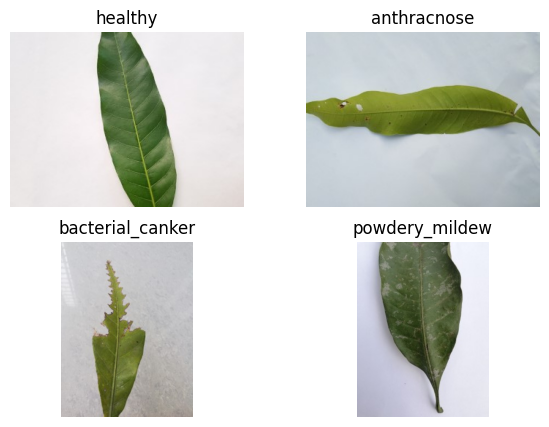

In [ ]:
plt.figure(figsize=(7, 5))
for i, class_name in enumerate(labels):
    class_dir = os.path.join(dataset_dir, class_name)
    image_name = os.listdir(class_dir)[0]
    image_path = os.path.join(class_dir, image_name)

    # Open the image
    img = Image.open(image_path)

    # Display the image
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.show()

# 3. Data Preparation

### 3.1 Data Splitting

In [ ]:
# Split dataset into training (80%), validation (10%), and testing (10%)
splitfolders.ratio('./MangoLeafsDisease/MangoLeafsDisease',
                   output='./MangoLeafsDisease/MangoLeafsDisease_split',
                   seed=1337, ratio=(.8, .1, .1),
                   group_prefix=None, move=False)

Copying files: 2000 files [00:00, 2226.85 files/s]


In [ ]:
# Define directories for training, validation, and testing data
train_dir = './MangoLeafsDisease/MangoLeafsDisease_split/train'
val_dir = './MangoLeafsDisease/MangoLeafsDisease_split/val'
test_dir = './MangoLeafsDisease/MangoLeafsDisease_split/test'

# Display labels in the training set
labels = [name for name in os.listdir(train_dir) if
          os.path.isdir(os.path.join(train_dir, name))]
print(labels)

['healthy', 'anthracnose', 'bacterial_canker', 'powdery_mildew']


### 3.2 Data Augmentation

In [ ]:
# Function to create data generators for training, validation, and testing
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
    # Augment and normalize training data
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

    # Create generator for training data
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

    # Normalize validation data without augmentation
    validation_datagen = ImageDataGenerator(rescale=1.0/255.)

    # Create generator for validation data
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                    batch_size=32,
                                                                    class_mode='categorical',
                                                                    target_size=(224, 224))

    # Normalize test data without augmentation
    testing_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Create generator for test data
    testing_generator = testing_datagen.flow_from_directory(directory=TESTING_DIR,
                                                  batch_size=32,
                                                  class_mode="categorical",
                                                  target_size=(224, 224),
                                                  shuffle=False)

    return train_generator, validation_generator, testing_generator

# Generate data for training, validation, and testing
train_generator, validation_generator, testing_generator = train_val_generators(train_dir, val_dir, test_dir)

Found 1600 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [ ]:
# Generate training, validation, and testing data
train_generator, validation_generator, testing_generator = train_val_generators(train_dir, val_dir, test_dir)

Found 1600 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


# 4. Modeling Menggunakan Model Convolutional Neural Network (CNN)

### 4.1 Convolutional Neural Network (CNN) Model

In [ ]:
# Create a Convolutional Neural Network (CNN) model
model = models.Sequential([
    # convolutional and pooling layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D(2, 2),
    # Flatten layer
    layers.Flatten(),
    # Fully connected layer
    layers.Dense(256, activation='relu'),
    # Dropout layer to prevent overfitting
    layers.Dropout(0.2),
    # Output layer with softmax activation (for multi-class classification)
    layers.Dense(4, activation='softmax')
])

# Display model architecture summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         409,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 541,060 (2.06 MB)

 Trainable params: 541,060 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Compiling Model

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam optimizer with learning rate 0.0001
    metrics=['accuracy']  # Track accuracy metric
)

### 4.3 Model Training

In [ ]:
# Train the CNN model
history = model.fit(
    train_generator,
    epochs=10,
    batch_size=32,
    validation_data=validation_generator,
    verbose=2
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 - 31s - 622ms/step - accuracy: 0.3050 - loss: 1.3715 - val_accuracy: 0.4550 - val_loss: 1.3207
Epoch 2/10
50/50 - 20s - 393ms/step - accuracy: 0.4919 - loss: 1.2378 - val_accuracy: 0.7800 - val_loss: 0.9285
Epoch 3/10
50/50 - 19s - 385ms/step - accuracy: 0.6900 - loss: 0.8677 - val_accuracy: 0.8400 - val_loss: 0.5455
Epoch 4/10
50/50 - 20s - 409ms/step - accuracy: 0.8100 - loss: 0.5712 - val_accuracy: 0.9400 - val_loss: 0.3093
Epoch 5/10
50/50 - 20s - 392ms/step - accuracy: 0.8469 - loss: 0.4293 - val_accuracy: 0.8650 - val_loss: 0.2993
Epoch 6/10
50/50 - 19s - 371ms/step - accuracy: 0.8781 - loss: 0.3654 - val_accuracy: 0.8900 - val_loss: 0.2700
Epoch 7/10
50/50 - 19s - 385ms/step - accuracy: 0.8769 - loss: 0.3323 - val_accuracy: 0.9750 - val_loss: 0.1421
Epoch 8/10
50/50 - 18s - 369ms/step - accuracy: 0.9175 - loss: 0.2563 - val_accuracy: 0.9650 - val_loss: 0.1126
Epoch 9/10
50/50 - 19s - 385ms/step - accuracy: 0.9194 - loss: 0.2348 - val_accuracy: 0.9800 - val_loss:

### 4.4 Model Accuracy and Loss During Training and Validation



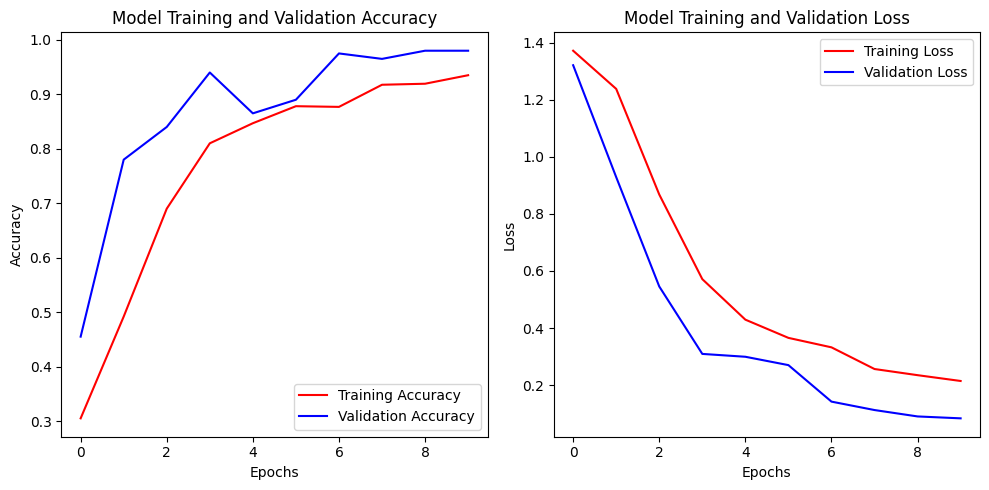

In [ ]:
# Retrieve accuracy and loss values from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Create two subplots (1 row, 2 columns) for training history visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training and validation accuracy
ax1.plot(epochs, acc, 'r', label='Training Accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax1.set_title('Model Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and validation loss
ax2.plot(epochs, loss, 'r', label='Training Loss')
ax2.plot(epochs, val_loss, 'b', label='Validation Loss')
ax2.set_title('Model Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust plot layout
plt.tight_layout()

# Show plots
plt.show()

### 4.5 Saving The Model

In [ ]:
# Save the trained model
model.save('mango_cnn.keras')

### 4.6 Loading The Model

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model('mango_cnn.keras')

# 5. Evaluation

### 5.1 Evaluating Model Performance

In [ ]:
# Evaluate the model on the test dataset
print('Evaluate model accuracy on test data')
model_results = saved_model.evaluate(testing_generator, batch_size=32)
print('Test Loss, Test Accuracy:', model_results)

Evaluate model accuracy on test data
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9754 - loss: 0.0837
Test Loss, Test Accuracy: [0.0994306281208992, 0.9700000286102295]


### 5.2 Confusion Matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


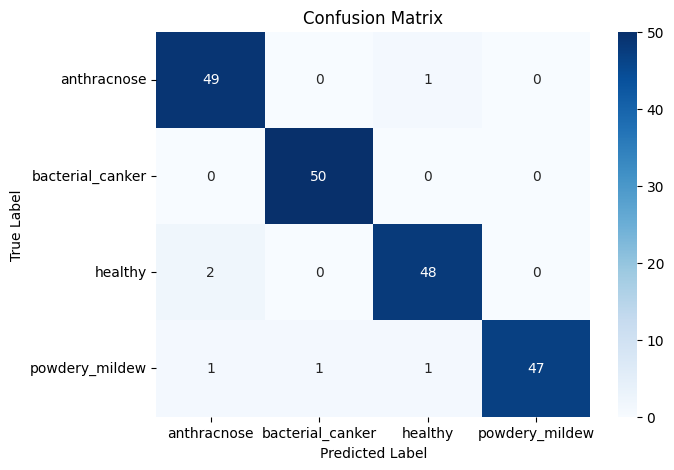

In [ ]:
# Perform predictions on the test dataset
predictions = saved_model.predict(testing_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

# Retrieve true labels from the test dataset
true_classes = testing_generator.classes
class_labels = list(testing_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### C. Predicting Test Set Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


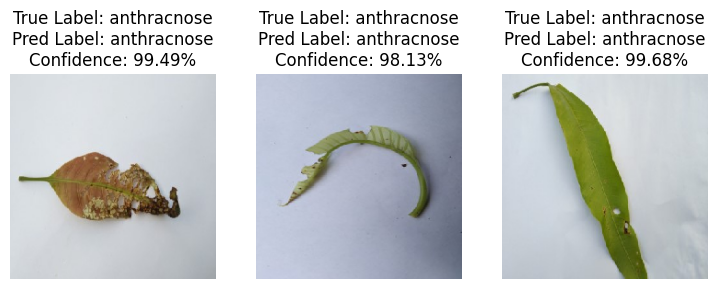

In [ ]:
# Retrieve sample images and labels from the test dataset
test_images, test_labels = next(testing_generator)

# Perform predictions on the sample images
predictions = saved_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Create a list of image indices
indices = list(range(len(test_images)))

# Shuffle indices randomly
random.shuffle(indices)

# Display 3 images along with their actual and predicted labels
plt.figure(figsize=(9, 7))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    index = indices[i]
    plt.imshow(test_images[index])

    # Retrieve true and predicted labels
    true_label = class_labels[true_classes[index]]
    predicted_label = class_labels[predicted_classes[index]]

    # Calculate prediction confidence
    accuracy = np.max(predictions[index]) * 100

    plt.title(f'True Label: {true_label}\nPred Label: {predicted_label}\nConfidence: {accuracy:.2f}%')
    plt.axis('off')

plt.show()

- Aggarwal, C.C., 2018. *Neural networks and deep learning.* 10th ed. Cham: Springer.  

- Alzubaidi, L., Zhang, J., Humaidi, A.J., Al-Dujaili, A., Duan, Y., Al-Shamma, O., Santamaría, J., Fadhel, M.A., Al-Amidie, M. and Farhan, L., 2021. Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. *Journal of Big Data,* 8, pp.1-74.  

- Chollet, F., 2021. *Deep learning with Python.* Available at: <https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf> [Accessed 1 October 2024].  

- Ghosh, A., Ghosh, S., Choubey, D.K. and Das, P., 2020. Fundamental concepts of convolutional neural network. In: *Recent trends and advances in artificial intelligence and Internet of Things.* Cham: Springer, pp.519-567.  

- Han, X., Jin, X. and Li, C., 2021. Pre-trained models: Past, present and future. *AI Open,* 2, pp.225-250.  

- Kumar, T., Kumar, A., Tripathi, A. and Singh, S., 2023. Image data augmentation approaches: A comprehensive survey and future directions. *arXiv preprint* arXiv:2301.02830.  

- López, O.A.M., Pérez, F.B., López, J.R.R. and Hernández, L.G.P., 2022. Multivariate statistical machine learning methods for genomic prediction. Available at: <https://doi.org/10.1007/978-3-030-89010-0_10> [Accessed 2 October 2024].  

- Narkhede, S., 2018. Understanding confusion matrix. Available at: <https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62> [Accessed 2 October 2024].  

- Saragih, V.R., Purba, T.S., Sitompul, M.R. and Lumbanraja, F.R., 2024. Detection of mango leaf disease using the convolution neural network method. *TEKNOSAINS: Jurnal Sains, Teknologi dan Informatika,* 11(1), pp.62-70.  

- Simonyan, K. and Zisserman, A., 2015. Very deep convolutional networks for large-scale image recognition. *arXiv preprint* arXiv:1409.1556.  

- TensorFlow, n.d. *TensorFlow.* Available at: <https://www.tensorflow.org/> [Accessed 4 October 2024].  

- Uzair, M. and Jamil, N., 2020. Effects of hidden layers on the efficiency of neural networks. In: *2020 IEEE 23rd International Multitopic Conference (INMIC).* IEEE, pp.1-6.  

- Xu, Y. and Goodacre, R., 2018. On splitting training and validation set: A comparative study of cross-validation, bootstrap and systematic sampling for estimating the generalization performance of supervised learning. *Journal of Analysis and Testing,* 2(3), pp.249-262.  

This Case Study in the Practical Work is a Scientific Writing by Felix Windriyareksa Hardyan, student of the Informatics Study Program at Gunadarma University with the title 'Comparison of 3 Convolutional Neural Network (CNN) Architectures for Mango Leaf Disease Classification' in the year 2024.

---


Copyright © 2024 by Pengelola MK Praktikum Unggulan (Praktikum DGX), Universitas Gunadarma


https://www.praktikum-hpc.gunadarma.ac.id/ <br>
https://www.hpc-hub.gunadarma.ac.id/ <br>
https://www.hpc-hub.gunadarma.ac.id/kontak/tim-pengembang-aplikasi/